<a href="https://colab.research.google.com/github/Sanjayvaradha/Projects/blob/main/Traffic_sign_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [143]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [144]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
import random
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Dropout,Flatten
import pandas as pd
import pickle
import cv2

In [145]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f: 
  valid_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

In [146]:
X_train,y_train = train_data['features'],train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [147]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not eqaul to number of labels"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images is not eqaul to number of labels"
assert(X_valid.shape[0]==y_valid.shape[0]), "The number of images is not eqaul to number of labels"
assert(X_train.shape[1:]==(32,32,3)), "The number of images are not 32*32*1"
assert(X_test.shape[1:]==(32,32,3)), "The number of images are not 32*32*1"
assert(X_valid.shape[1:]==(32,32,3)), "The number of images are not 32*32*1"

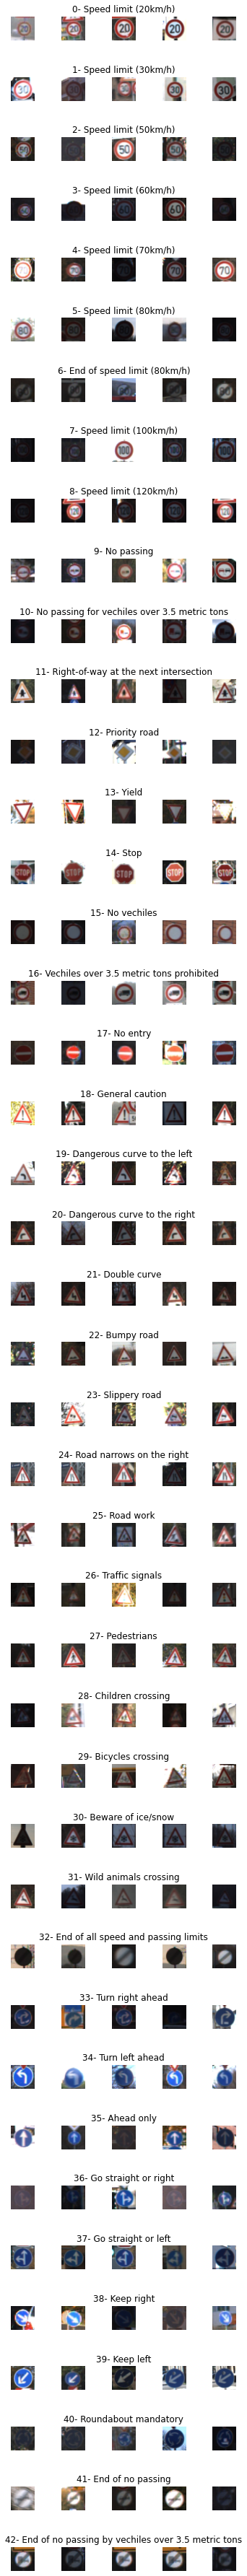

In [148]:
data = pd.read_csv("german-traffic-signs/signnames.csv")
num_samples = []
num_classes = 43
cols = 5
fig,axs = plt.subplots(nrows=num_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    x_selected = X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:], cmap = plt.get_cmap('gray') )
    axs[j][i].axis('off')
    if i ==2:

      axs[j][i].set_title(str(j) +  '- ' + row['SignName'])
      num_samples.append(len(x_selected))


In [149]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

In [150]:
def equalise(img):
  img = cv2.equalizeHist(img)
  return img

In [151]:
def preprocess(img):
  img = grayscale(img)
  img = equalise(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocess, X_train))) # map - iterate through entire array in format of list 2nd arg-which one is going to process
X_valid = np.array(list(map(preprocess, X_valid))) 
X_test = np.array(list(map(preprocess, X_test))) 

In [152]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)

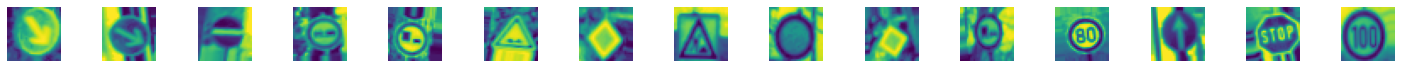

In [153]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,                                     
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                rotation_range=10,
                                shear_range= 0.1                                                                     
                               )
datagen.fit(X_train)
batches = datagen.flow(X_train,y_train,batch_size=15)
X_batch,y_batch = next(batches)


fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')


In [154]:
y_train = to_categorical(y_train,43)
y_valid = to_categorical(y_valid,43)
y_test = to_categorical(y_test,43)

In [155]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [156]:
model = modified_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 480)              

In [157]:

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=20),
                            steps_per_epoch=1500,
                            epochs=10,
                            validation_data=(X_valid, y_valid), shuffle = 1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1500/1500 [==============================] - 13s 9ms/step - loss: 2.1515 - accuracy: 0.4045 - val_loss: 0.2596 - val_accuracy: 0.9268
Epoch 2/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3560 - accuracy: 0.8861 - val_loss: 0.1527 - val_accuracy: 0.9571
Epoch 3/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2225 - accuracy: 0.9305 - val_loss: 0.0900 - val_accuracy: 0.9730
Epoch 4/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1794 - accuracy: 0.9459 - val_loss: 0.0680 - val_accuracy: 0.9805
Epoch 5/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1360 - accuracy: 0.9592 - val_loss: 0.0996 - val_accuracy: 0.9735
Epoch 6/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.1257 - accuracy: 0.9616 - val_loss: 0.1406 - val_accuracy: 0.9649
Epoch 7/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.1126 - accuracy: 0.9646 - val_loss: 0.0814 - val_accuracy: 0.9

In [158]:
score = model.evaluate(X_test,y_test,verbose=0)
print(score)

[0.14935438334941864, 0.9618368744850159]


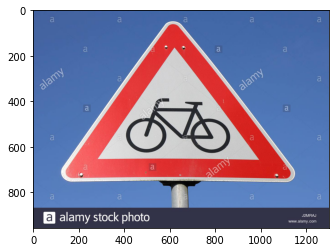

In [159]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


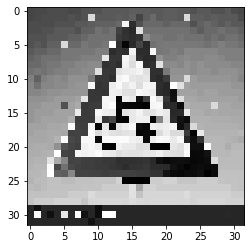

In [160]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [161]:
img = img.reshape(1, 32, 32, 1)

In [162]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [29]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
